In [1]:
import qutip as qt
import numpy as np
from matplotlib import pylab as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import scipy as scp
from scipy import stats
%matplotlib inline

## Data Loading

In [2]:
## Loading of previously saved data
N = 1021
steps = 500
data = np.load('data.npz')
qresults = data['qresults']
cresults = data['cresults']
quantum = data['quantumP500']
classic = data['classicalP500']
xq = data['xq']
x = data['x']

## Setup

In [13]:
## Declaration of unitary evolution operators
N = 1021
## Initial Quantum State
psisim = (qt.tensor(qt.basis(2,1),qt.basis(N,N/2-3)) + 1j*qt.tensor(qt.basis(2,0),qt.basis(N,N/2-3))).unit()
## Hadamard Operator
H = qt.hadamard_transform(N=1)
I = qt.qeye(N=N)
## Coin Operator
C = qt.tensor(H,I)
## Conditional Displacement Operator
S0 = qt.Qobj(np.zeros((N,N)))
S1 = qt.Qobj(np.zeros((N,N)))
for i in range(N-1):
    S0+= qt.basis(N,i+1)*qt.basis(N,i).dag()
Sd  = qt.tensor(qt.basis(2,1)*qt.basis(2,1).dag(),S0)
for i in range(1,N):
    S1+= qt.basis(N,i-1)*qt.basis(N,i).dag()
Si  = qt.tensor(qt.basis(2,0)*qt.basis(2,0).dag(),S1)
S = Sd + Si

## Classical - Quantum Probability Comparison
### Steps = 500

In [14]:
## Quantum Walk Routine Defintion
def qw(coin,shift,psi_ini,steps):
    U = (S*C)**steps
    quantum = (((U*psi_ini).unit()).ptrace(1)).diag()
    xq = np.arange(-1*(len(quantum)/2),len(quantum)/2+1)
    return (xq,quantum)

In [15]:
## "Unbiased" Random Walk
def ucrw(steps):
    '''
    Unbiased classical random walk. p=q=1/2
    '''
    x = np.arange(-(steps) , steps+1)
    classic = np.zeros(2*steps+1)+(np.mod(x+steps,2)==0)*(1./(2**steps))*scp.special.binom(steps,(x+steps)/2.)
    return (x,classic)

In [16]:
steps = 500

In [17]:
xq,quantum=qw(C,S,psisim,steps)

In [18]:
x,classic=ucrw(steps)

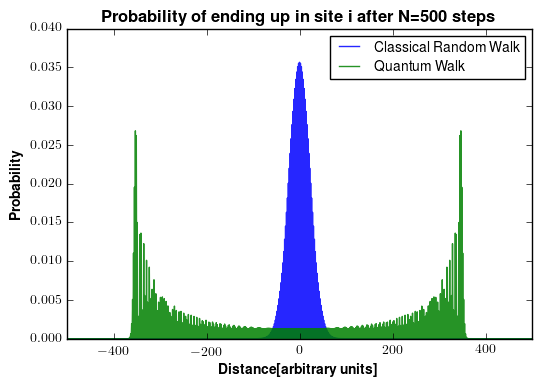

In [20]:
plt.plot(x,classic,label="Classical Random Walk",alpha=0.85)
plt.plot(xq,quantum,label="Quantum Walk",alpha=0.85)
plt.legend(fontsize=10)
plt.xlim(-steps,steps)
plt.xlabel(r"\textbf{Distance[arbitrary units]}")
plt.ylabel(r"\textbf{Probability}")
plt.title(r"\textbf{Probability of ending up in site i after N=500 steps}")
plt.savefig("probability.png")

## Variance Behavior

In [21]:
## Simulating for different steps number
qresults = []
cresults = []
for i in range(25,steps+1,25):
    cresults.append(ucrw(i))
    qresults.append(qw(C,S,psisim,steps=i))

In [4]:
## Saved simulated data
np.savez('data', x=x,xq=xq,classicalP500=classic, quantumP500=quantum, qresults =  qresults, cresults =cresults)

In [5]:
## Finding Mean and Variances for both type of walks
means_q = np.asarray([0 if np.isclose(np.sum(pair[0]*pair[1]),0) 
                      else np.sum(pair[0]*pair[1])  for pair in qresults])
means_c = np.asarray([0 if np.isclose(np.sum(pair[0]*pair[1]),0) 
           else np.sum(pair[0]*pair[1])  for pair in cresults])
expx2_q = np.asarray([0 if np.isclose(np.sum((pair[0]**2)*pair[1]),0) 
                      else np.sum((pair[0]**2)*pair[1])for pair in qresults])
expx2_c = np.asarray([0 if np.isclose(np.sum((pair[0]**2)*pair[1]),0) 
           else np.sum((pair[0]**2)*pair[1])for pair in cresults])
var_q = expx2_q - means_q**2
var_c = expx2_c - means_c**2

In [6]:
## Finding Regression Coefficients
xstep = np.arange(25,steps+1,25)
xreg = np.arange(10,10**3)
m_q, int_q, r_q, p_q, std_error_q = stats.linregress(np.log(xstep), np.log(var_q))
m_c, int_c, r_c, p_c, std_error_c = stats.linregress(np.log(xstep), np.log(var_c))
sigma_q = np.exp(m_q*np.log(xreg)+int_q)
sigma_c = np.exp(m_c*np.log(xreg)+int_c)

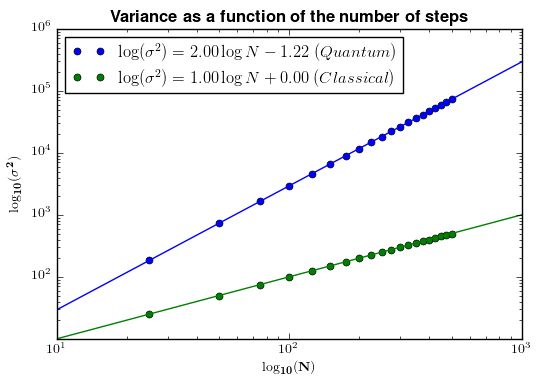

In [7]:
## Log-Log Plots
plt.loglog(xstep,var_q,'o',basex=10,ms=5,label=r"\(\log(\sigma^2)={0:.2f}\log N{1:.2f}\ (Quantum)\)".format(m_q,int_q))
plt.loglog(xstep,var_c,'o',basex=10,ms=5,label=r"\(\log(\sigma^2)={0:.2f}\log N+{1:.2f}\ (Classical)\)".format(m_c,int_c))
plt.loglog(xreg,sigma_q,'-',color='b')
plt.loglog(xreg,sigma_c,'-',color='g')
plt.legend(loc='best')
plt.ylabel(r"\(\mathbf{\log_{10}(\sigma^2)}\)")
plt.xlabel(r"\(\mathbf{\log_{10}(N)}\)")
plt.title(r"\textbf{Variance as a function of the number of steps}")
plt.savefig("variances.png")